# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from functions import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, MinMaxScaler
from sklearn import preprocessing
import scipy.stats as stats
from scipy.special import inv_boxcox
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as ticker
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

In [2]:
rent_df = pd.read_csv('/Users/ignaciolorenzoqueralt/Documents/Ironhack/Final Project/properties/rent/2021.11.17_cataluña_1300_5.csv', engine='python' )
rent_df = rent_df.loc[:, ~rent_df.columns.str.contains('^Unnamed')]

# Working on the data

### Adding sqm price for each neighborhood

In [3]:
rent_df['hood_price_m2'] = ""

for index, row in rent_df.iterrows():
    hood_price_m2 = rent_df[rent_df['neighborhood'] == rent_df['neighborhood'][index]]['price_m2'].mean()
    rent_df['hood_price_m2'][index] = hood_price_m2

### Cleaning the data

- Replacing nulls from last_update:

In [4]:
clean_last_update(rent_df, c = 'last_update')

- Replacing null values of lift column with 'no'. All properties with no lift data don't have a lift.

In [5]:
fill_lift_column(rent_df)

- Dealing with null values

In [6]:
checking_nulls(rent_df)

The column  area  has  11  null values
The column  floor  has  2511  null values
The column  ccaa  has  22  null values
The column  description  has  11  null values
The column  geo_town  has  36  null values
The column  m2  has  36  null values
The column  n_bath  has  36  null values
The column  n_rooms  has  36  null values
The column  name  has  36  null values
The column  neighborhood  has  36  null values
The column  opportunity  has  36  null values
The column  price  has  36  null values
The column  price_m2  has  61  null values
The column  price_reduction  has  61  null values
The column  province  has  61  null values
The column  url  has  61  null values
The column  hood_price_m2  has  61  null values


In [7]:
rent_df = rent_df.dropna()

In [8]:
rent_df.head(1)

,area,floor,ccaa,description,geo_town,last_update,lift,m2,n_bath,n_rooms,name,neighborhood,opportunity,price,price_m2,price_reduction,province,url,hood_price_m2
1,Arenys de Mar,first,cataluña,INMUEBLE NO SUJETO A LA LIMITACIÓN DE PRECIOS ...,arenys_de_mar,0.0,yes,70,1,3.0,Alquiler Apartamento N ii junquera. Por meses...,Urbanitzacions,no,900,12.0,80.0,barcelona,https://www.habitaclia.com/alquiler-apartament...,9.368421


- Creating df with the neighborhoods of the df and its hood_price_m2:

In [9]:
neighborhood_price_sqm = rent_df[['neighborhood','geo_town','hood_price_m2']].copy()
neighborhood_price_sqm.drop_duplicates(keep=False,inplace=True)
neighborhood_price_sqm = neighborhood_price_sqm.reset_index(drop=True)
neighborhood_price_sqm.head(3)

,neighborhood,geo_town,hood_price_m2
0,Zona alta,arenys_de_mar,9.333333
1,Nucli Urbà,argentona,8.384615
2,Montigalà,badalona,12.0


- Cleaning numerical variables

In [10]:
numericals = ['m2', 'n_rooms', 'n_bath', 'price_m2', 'price', 'price_reduction', 'last_update', 'hood_price_m2']
convert_to_numerical(rent_df, numericals)

- Filtering out towns in which there are less than x properties listed.

In [11]:
filtered_towns = list(rent_df['geo_town'].value_counts()[lambda x: x > 10].index)
rent_df = rent_df[rent_df['geo_town'].isin(filtered_towns)]

# Exploratory analysis

In [12]:
rent_df.head(3)

,area,floor,ccaa,description,geo_town,last_update,lift,m2,n_bath,n_rooms,name,neighborhood,opportunity,price,price_m2,price_reduction,province,url,hood_price_m2
1,Arenys de Mar,first,cataluña,INMUEBLE NO SUJETO A LA LIMITACIÓN DE PRECIOS ...,arenys_de_mar,0,yes,70,1,3,Alquiler Apartamento N ii junquera. Por meses...,Urbanitzacions,no,900,12,80,barcelona,https://www.habitaclia.com/alquiler-apartament...,9
2,Arenys de Mar,fourth,cataluña,Vivienda en la Urbanización Carolines de Areny...,arenys_de_mar,8,yes,89,1,2,"Alquiler Piso en Carrer mig (del), 20. Vivie...",Urbanitzacions,no,680,7,20,barcelona,https://www.habitaclia.com/alquiler-piso-vivie...,9
4,Arenys de Mar,second,cataluña,ALQUILER DE TEMPORADA - Bonito piso de 70 m2 t...,arenys_de_mar,13,yes,70,1,3,Alquiler Apartamento Carrer camí ral del caba...,Urbanitzacions,no,900,12,80,barcelona,https://www.habitaclia.com/alquiler-apartament...,9


In [13]:
rent_df.shape

(2276, 19)

In [14]:
rent_df.dtypes

area               object
floor              object
ccaa               object
description        object
geo_town           object
last_update         int64
lift               object
m2                  int64
n_bath              int64
n_rooms             int64
name               object
neighborhood       object
opportunity        object
price               int64
price_m2            int64
price_reduction     int64
province           object
url                object
hood_price_m2       int64
dtype: object

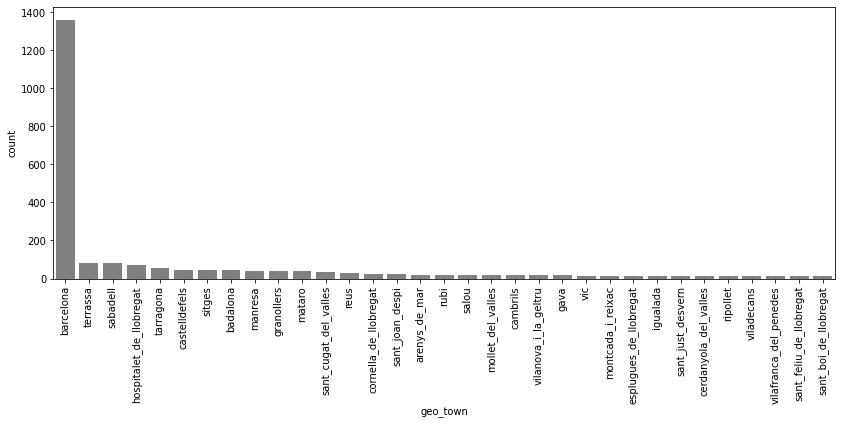

In [15]:
countplot(rent_df,c = "geo_town")

# Model

#### Feature selection

We skip neighborhood as it would add too many distinct categorical values which would increase too much the size of the model when encoding it.

## Model for small towns

In [16]:
model_df = rent_df[['m2', 'n_rooms', 'n_bath', 'last_update', 'geo_town', 'province', 'ccaa', 'price', 'lift', 'floor', 'hood_price_m2']].copy()

#### Filtering out big cities

In [17]:
model_df_small = model_df[model_df['geo_town'] != filtering_big_cities(model_df)]

#### Removing outliers

In [18]:
model_df_small = remove_outliers(model_df_small, threshold=1.5, in_columns = ['m2', 'n_rooms', 'last_update', 'price', 'hood_price_m2'])

#### Visualising our data

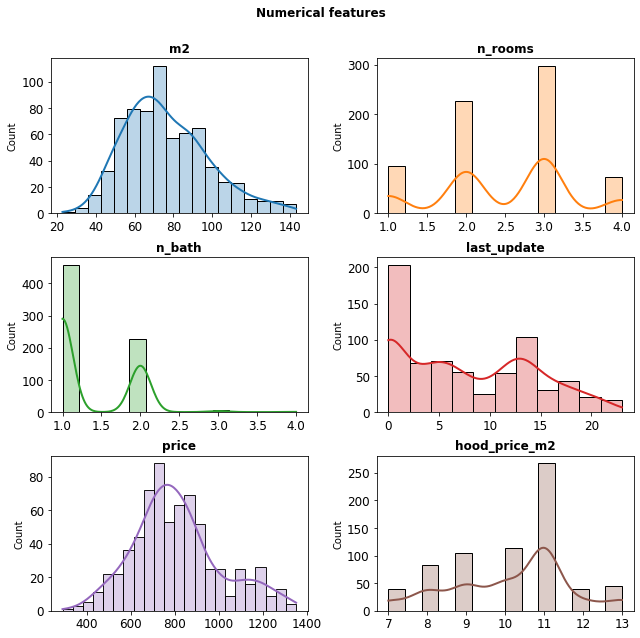

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))
axes = axes.flat
numeric_columns = model_df_small.select_dtypes(include=['float64', 'int']).columns

for i, column in enumerate(numeric_columns):
    sns.histplot(
        data    = model_df_small,
        x       = column,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(column, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 12)
    axes[i].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Numerical features', fontsize = 12, fontweight = "bold");

#### X-y Split

In [20]:
X = model_df_small.drop('price', axis=1)
y = model_df_small[['price']].copy()

#### Encoding categoricals and normalizing numericals

In [21]:
X_cat = X.select_dtypes('object')
X_num = X.select_dtypes('int')

X_cat_enc = pd.get_dummies(X_cat, drop_first=True)
X_num_norm, _ci = boxcox_transform(X_num)

X = np.concatenate([X_num_norm, X_cat_enc], axis=1)
X.shape

(693, 44)

#### Train-test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#### Fitting and running the model

In [23]:
model_small_city = LinearRegression()
model_small_city.fit(X_train, y_train)

predictions = model_small_city.predict(X_test)
r2 = r2_score(y_test, predictions)

In [24]:
print('R2: ', round(r2,4))
print('mean_absolute_error: ', mean_absolute_error(y_test, predictions))
print('mean_squared_error: ', mean_squared_error(y_test, predictions, squared=False))
print('y_test price mean: ', y_test['price'].mean())
print('y_train price mean: ', y_train['price'].mean())

R2:  0.6824
mean_absolute_error:  93.43890626461663
mean_squared_error:  120.8962614544325
y_test price mean:  815.4134615384615
y_train price mean:  809.0907216494845


In [25]:
y_test['predicted'] = predictions
y_test['difference_%'] = ((y_test['predicted']-y_test['price'])/y_test['predicted'])*100

<AxesSubplot:xlabel='difference_%', ylabel='Count'>

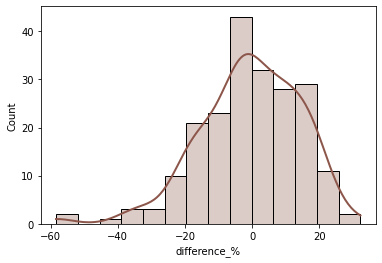

In [26]:
sns.histplot(
        x       = y_test.sort_values(by="difference_%", ascending=False)['difference_%'],
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3
)

Gridsearch

In [27]:
pipe = Pipeline(steps=[('estimator', LinearRegression())])

In [28]:
params_grid = [ {'estimator':[LinearRegression()],
                },
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[50,100, 200, 300],
                'estimator__max_depth':[1,2,3, None],
                'estimator__min_samples_split':[2,3, None],
                'estimator__min_samples_leaf':[1,2],
               }
              ]

In [29]:
grid = GridSearchCV(pipe, params_grid, n_jobs =-1, verbose = 2)
res = grid.fit(X, y)

Fitting 5 folds for each of 97 candidates, totalling 485 fits


In [30]:
grid.best_params_

{'estimator': RandomForestRegressor(n_estimators=200),
 'estimator__max_depth': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__n_estimators': 200}

In [31]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010390,0.006202,0.002619,0.000328,LinearRegression(),NaN,NaN,NaN,NaN,{'estimator': LinearRegression()},0.507035,0.456329,0.443220,0.439637,0.033266,0.375898,0.173007,14
1,0.108500,0.002837,0.008901,0.000166,RandomForestRegressor(n_estimators=200),1,1,2,50,{'estimator': RandomForestRegressor(n_estimato...,0.284166,0.308930,0.139461,0.158690,-0.465082,0.085233,0.283125,61
2,0.223826,0.006649,0.031558,0.026892,RandomForestRegressor(n_estimators=200),1,1,2,100,{'estimator': RandomForestRegressor(n_estimato...,0.283116,0.304749,0.138291,0.156013,-0.441176,0.088199,0.272849,55
3,0.408352,0.012486,0.027475,0.000505,RandomForestRegressor(n_estimators=200),1,1,2,200,{'estimator': RandomForestRegressor(n_estimato...,0.273458,0.305885,0.145661,0.162614,-0.452752,0.086973,0.276828,57
4,0.617765,0.012954,0.040776,0.002487,RandomForestRegressor(n_estimators=200),1,1,2,300,{'estimator': RandomForestRegressor(n_estimato...,0.279585,0.306174,0.143797,0.168732,-0.460018,0.087654,0.280805,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1.151566,0.022034,0.046234,0.002260,RandomForestRegressor(n_estimators=200),None,2,3,300,{'estimator': RandomForestRegressor(n_estimato...,0.479791,0.463880,0.421391,0.463704,0.057313,0.377216,0.161122,12
93,0.035699,0.002102,0.000000,0.000000,RandomForestRegressor(n_estimators=200),None,2,None,50,{'estimator': RandomForestRegressor(n_estimato...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69
94,0.065424,0.002606,0.000000,0.000000,RandomForestRegressor(n_estimators=200),None,2,None,100,{'estimator': RandomForestRegressor(n_estimato...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70
95,0.127520,0.002929,0.000000,0.000000,RandomForestRegressor(n_estimators=200),None,2,None,200,{'estimator': RandomForestRegressor(n_estimato...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90


#### Evaluating variables

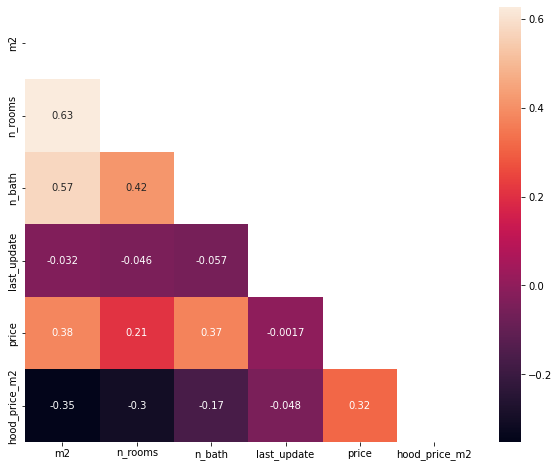

In [32]:
# check the correlations
mask = np.zeros_like(model_df.corr())

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(model_df.corr(), mask=mask, annot=True)
plt.show()


In [33]:
X_num = sm.add_constant(X_num) # we need to add this constant value for the intercepts
model = sm.OLS(y, X_num).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     151.7
Date:                Tue, 23 Nov 2021   Prob (F-statistic):          2.06e-108
Time:                        23:04:21   Log-Likelihood:                -4397.4
No. Observations:                 693   AIC:                             8807.
Df Residuals:                     687   BIC:                             8834.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -548.0839     83.533     -6.561      0.000    -712.094    -384.074
m2              158.4439     13.279     11.932      0.000     132.372     184.516
n_rooms         -14.4826      7.890     -1.835      0.067     -29.975       1.010
n_bath          423.3400     45.833      9.236      0.000     333.350     513.330
last_update       0.7733      2.193      0.353      0.724      -3.533       5.079
hood_price_m2    11.2512      0.752     14.958      0.000       9.774      12.728
==============================================================================
Omnibus:                       28.360   Durbin-Watson:                   1.444
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.490
Skew:                           0.398   Prob(JB):                     1.19e-08
Kurtosis:                       3.793   Cond. No.                         507.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model for big cities

In [34]:
model_df = rent_df[['geo_town', 'm2', 'n_rooms', 'n_bath', 'last_update', 'price', 'lift', 'floor', 'hood_price_m2', 'neighborhood']].copy()

#### Filtering out small towns

In [35]:
model_df_big = model_df[model_df['geo_town'] == filtering_big_cities(model_df)]

In [36]:
filtered_neighborhoods = list(model_df_big['neighborhood'].value_counts()[lambda x: x > 10].index)
model_df_big = model_df_big[model_df_big['neighborhood'].isin(filtered_neighborhoods)]
model_df_big.shape

(1207, 10)

#### Removing outliers

In [37]:
model_df_big = remove_outliers(model_df_big, threshold=1.5, in_columns = ['m2', 'n_rooms', 'last_update', 'price', 'hood_price_m2'])

#### Visualising our data

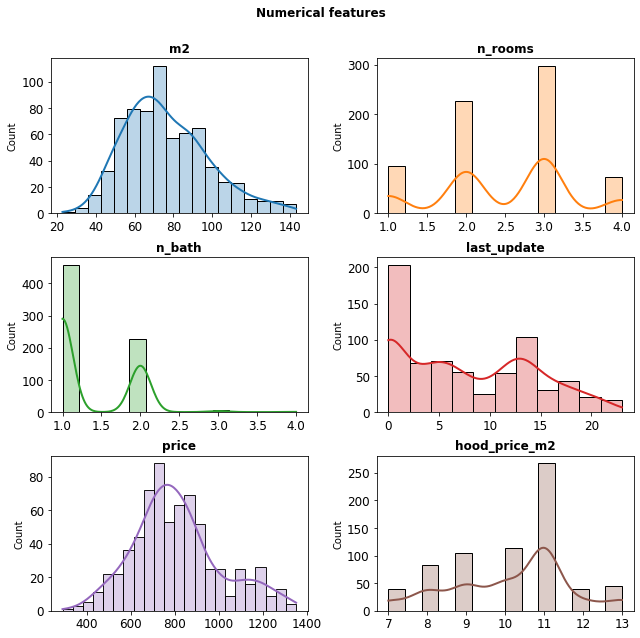

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))
axes = axes.flat
numeric_columns = model_df_big.select_dtypes(include=['float64', 'int']).columns

for i, column in enumerate(numeric_columns):
    sns.histplot(
        data    = model_df_small,
        x       = column,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(column, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 12)
    axes[i].set_xlabel("")
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Numerical features', fontsize = 12, fontweight = "bold");

#### X-y Split

In [39]:
X = model_df_big.drop('price', axis=1)
y = model_df_big[['price']].copy()

#### Encoding categoricals and normalizing numericals

In [40]:
X_cat = X.select_dtypes('object')
X_num = X.select_dtypes('int')

X_cat_enc = pd.get_dummies(X_cat, drop_first=True)
X_num_norm, _ci = boxcox_transform(X_num)

X = np.concatenate([X_num_norm, X_cat_enc], axis=1)
X.shape

(1152, 45)

#### Train-test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#### Fitting and running the model

In [42]:
model_big_city = LinearRegression()
model_big_city.fit(X_train, y_train)

predictions = model_big_city.predict(X_test)
r2 = r2_score(y_test, predictions)

In [43]:
predictions = model_big_city.predict(X_test)
r2 = r2_score(y_test, predictions)

In [44]:
print('R2: ', round(r2,4))
print('mean_absolute_error: ', mean_absolute_error(y_test, predictions))
print('mean_squared_error: ', mean_squared_error(y_test, predictions, squared=False))
print('y_test price mean: ', y_test['price'].mean())
print('y_train price mean: ', y_train['price'].mean())

R2:  0.3783
mean_absolute_error:  126.153270919888
mean_squared_error:  159.0544922255188
y_test price mean:  1019.7283236994219
y_train price mean:  1017.8424317617867


In [45]:
y_test['predicted'] = predictions
y_test['difference_%'] = ((y_test['predicted']-y_test['price'])/y_test['predicted'])*100

<AxesSubplot:xlabel='difference_%', ylabel='Count'>

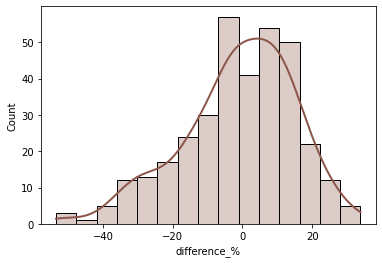

In [46]:
sns.histplot(
        x       = y_test.sort_values(by="difference_%", ascending=False)['difference_%'],
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3
)

In [47]:
pipe = Pipeline(steps=[('estimator', LinearRegression())])

params_grid = [ {'estimator':[LinearRegression()],
                },
               {'estimator': [RandomForestRegressor()],
               'estimator__n_estimators':[50,100, 200, 300],
                'estimator__max_depth':[1,2,3, None],
                'estimator__min_samples_split':[2,3, None],
                'estimator__min_samples_leaf':[1,2],
               }
              ]

grid = GridSearchCV(pipe, params_grid, n_jobs =-1, verbose = 2)
res = grid.fit(X, y)

grid.best_params_

Fitting 5 folds for each of 97 candidates, totalling 485 fits


{'estimator': RandomForestRegressor(min_samples_leaf=2, min_samples_split=3),
 'estimator__max_depth': None,
 'estimator__min_samples_leaf': 2,
 'estimator__min_samples_split': 3,
 'estimator__n_estimators': 100}

In [48]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007138,0.002396,0.002770,0.000512,LinearRegression(),NaN,NaN,NaN,NaN,{'estimator': LinearRegression()},0.349342,0.444854,0.320934,-0.117220,0.338414,0.267265,0.197000,17
1,0.134075,0.008968,0.011162,0.003453,"RandomForestRegressor(min_samples_leaf=2, min_...",1,1,2,50,{'estimator': RandomForestRegressor(min_sample...,0.235416,0.265182,0.186664,-0.252005,0.179315,0.122914,0.190109,55
2,0.242069,0.017123,0.020772,0.006905,"RandomForestRegressor(min_samples_leaf=2, min_...",1,1,2,100,{'estimator': RandomForestRegressor(min_sample...,0.240287,0.259699,0.182772,-0.237971,0.174706,0.123899,0.183840,51
3,0.460115,0.023468,0.027022,0.000727,"RandomForestRegressor(min_samples_leaf=2, min_...",1,1,2,200,{'estimator': RandomForestRegressor(min_sample...,0.235709,0.265785,0.181358,-0.242014,0.175807,0.123329,0.185753,53
4,0.672517,0.009902,0.039572,0.000824,"RandomForestRegressor(min_samples_leaf=2, min_...",1,1,2,300,{'estimator': RandomForestRegressor(min_sample...,0.227868,0.266213,0.187671,-0.248975,0.174656,0.121487,0.187996,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1.623045,0.032228,0.048737,0.004504,"RandomForestRegressor(min_samples_leaf=2, min_...",None,2,3,300,{'estimator': RandomForestRegressor(min_sample...,0.430127,0.452172,0.398070,0.142668,0.359668,0.356541,0.111388,4
93,0.039424,0.002728,0.000000,0.000000,"RandomForestRegressor(min_samples_leaf=2, min_...",None,2,None,50,{'estimator': RandomForestRegressor(min_sample...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69
94,0.064538,0.001738,0.000000,0.000000,"RandomForestRegressor(min_samples_leaf=2, min_...",None,2,None,100,{'estimator': RandomForestRegressor(min_sample...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70
95,0.131242,0.011567,0.000000,0.000000,"RandomForestRegressor(min_samples_leaf=2, min_...",None,2,None,200,{'estimator': RandomForestRegressor(min_sample...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90


#### Evaluating variables

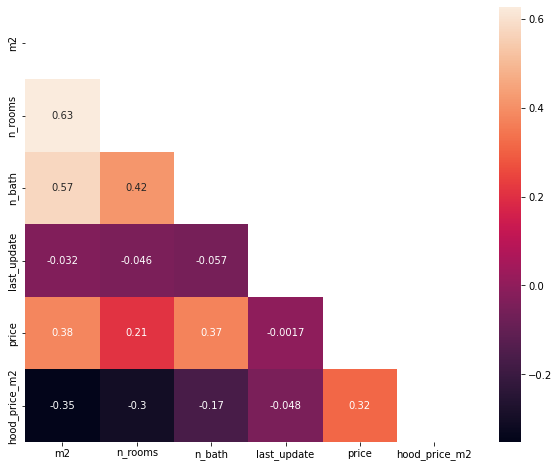

In [49]:
# check the correlations
mask = np.zeros_like(model_df.corr())

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(model_df.corr(), mask=mask, annot=True)
plt.show()

In [50]:
X_num = sm.add_constant(X_num) # we need to add this constant value for the intercepts
model = sm.OLS(y, X_num).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     105.5
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           1.12e-91
Time:                        23:05:19   Log-Likelihood:                -7538.9
No. Observations:                1152   AIC:                         1.509e+04
Df Residuals:                    1146   BIC:                         1.512e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -678.2055    262.976     -2.579      0.010   -1194.174    -162.237
m2               32.7603      1.978     16.566      0.000      28.880      36.640
n_rooms         -43.7290     10.069     -4.343      0.000     -63.484     -23.974
n_bath          339.3856     70.117      4.840      0.000     201.814     476.958
last_update      10.6690      2.042      5.225      0.000       6.662      14.676
hood_price_m2   725.1296    178.460      4.063      0.000     374.984    1075.275
==============================================================================
Omnibus:                       32.506   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.758
Skew:                           0.385   Prob(JB):                     7.71e-08
Kurtosis:                       2.700   Cond. No.                     1.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Finding the most profitable towns to Buy & Rent

1. Importar df con propiedades en venta
2. Distinguir entre propiedades que pertenecen a modelo de ciudad grande o pequeña
- Seleccionar varialbes de un modelo y de otro
- filtrar poblaciones de propiedades en venta que no estan en los municipios del modelo
3. Sacar tabla de predicciones para modelo grande y pequeña
4. concatenar tabla de predicciones
5. Merge con info de precios de venta
6. Calcular ROI
7. Visualizacion

### Importar df con propiedades en venta

In [51]:
df_sale = pd.read_csv('/Users/ignaciolorenzoqueralt/Documents/Ironhack/Final Project/properties/sale/2021.11.15_cataluña_90000_10.csv', engine = 'python')

### Distinguir entre propiedades que pertenecen a modelo de ciudad grande o pequeña

In [53]:
df_sale_big = df_sale[df_sale['geo_town'] == filtering_big_cities(model_df)]
df_sale_small = df_sale[df_sale['geo_town'] != filtering_big_cities(model_df)]

#### Cleaning big city sale df

In [54]:
df_sale_big['hood_price_m2'] = ""

In [55]:
df_sale_big = df_sale_big[['geo_town', 'm2', 'n_rooms', 'n_bath', 'last_update', 'price', 'lift', 'floor', 'hood_price_m2', 'neighborhood']].copy()

In [56]:
clean_last_update(df_sale_big, c = 'last_update')

In [57]:
fill_lift_column(df_sale_big)

In [58]:
checking_nulls(df_sale_big)

The column  floor  has  99  null values


In [59]:
df_sale_big = df_sale_big.dropna()

In [60]:
df_sale_big.shape

(64, 10)

In [61]:
df_sale_big1 = df_sale_big.copy()

In [62]:
df_sale_big1 = df_sale_big1.merge(neighborhood_price_sqm, on='neighborhood', how='inner')
df_sale_big1 = df_sale_big1.drop(["geo_town_x", "hood_price_m2_x"], axis = 1)
df_sale_big1.columns = ['m2', 'n_rooms', 'n_bath', 'last_update', 'price', 'lift', 'floor', 'neighborhood', 'geo_town', 'hood_price_m2']

In [63]:
new_row = {'geo_town':'dumb', 'm2':87, 'n_rooms':92, 'n_bath':97, 'last_update':97, 'price':97, 'lift':'yes', 'floor':"ground", 'hood_price_m2':97, 'neighborhood': 'Eixample'}
df_sale_big1 = df_sale_big1.append(new_row, ignore_index=True)

In [66]:
numericals = ['m2', 'n_rooms', 'n_bath', 'price', 'last_update', 'hood_price_m2']
convert_to_numerical(df_sale_big1, numericals)

In [67]:
X_cat = df_sale_big1.select_dtypes('object')
X_num = df_sale_big1.select_dtypes('int')

In [68]:
X_cat_enc = pd.get_dummies(X_cat, drop_first=True)
X_num_norm, _ci = boxcox_transform(X_num)
X = np.concatenate([X_num_norm, X_cat_enc], axis=1)
X.shape

(13, 15)

### Fit model to both dfs

In [69]:
predictions_big_city = model_big_city.predict(X)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 45 is different from 15)

# Si mi modelo es para predecir precios que no estan en el df del train test, una vez optimizado el modelo, que sentido tiene tener un test split?